

## Tiny next-character generator using a single neuron (toy model)

Goal:
- Build a next-character prediction model using a single linear neuron.
- This model will learn: `next_char = f(current_char)`
- Then generate text by sampling predicted next characters.

Note:
A single neuron cannot learn complex patterns, but it demonstrates how **generation** works.



### Imports and configs

In [1]:
import numpy as np
from collections import Counter
np.random.seed(42)

In [2]:
path = "data/alice.txt"

with open(path, "r", encoding="utf-8") as f:
    text = f.read().lower()

print("Characters:", len(text))
print("Preview:", text[:200])


Characters: 148574
Preview: alice's adventures in wonderland

                alice's adventures in wonderland

                          lewis carroll

               the millennium fulcrum edition 3.0




                     


## Build character vocabulary

We need:
- char2idx
- idx2char
- vocab_size
- one-hot representation

This is identical to before, but now labels = next character.




In [3]:
chars = sorted(list(set(text)))
vocab_size = len(chars)
print("Vocab size:", vocab_size)
print(chars)



Vocab size: 46
['\n', ' ', '!', '"', "'", '(', ')', '*', ',', '-', '.', '0', '3', ':', ';', '?', '[', ']', '_', '`', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


In [4]:

char2idx = {ch:i for i,ch in enumerate(chars)}
idx2char = {i:ch for ch,i in char2idx.items()}

print(char2idx)
print(idx2char)


{'\n': 0, ' ': 1, '!': 2, '"': 3, "'": 4, '(': 5, ')': 6, '*': 7, ',': 8, '-': 9, '.': 10, '0': 11, '3': 12, ':': 13, ';': 14, '?': 15, '[': 16, ']': 17, '_': 18, '`': 19, 'a': 20, 'b': 21, 'c': 22, 'd': 23, 'e': 24, 'f': 25, 'g': 26, 'h': 27, 'i': 28, 'j': 29, 'k': 30, 'l': 31, 'm': 32, 'n': 33, 'o': 34, 'p': 35, 'q': 36, 'r': 37, 's': 38, 't': 39, 'u': 40, 'v': 41, 'w': 42, 'x': 43, 'y': 44, 'z': 45}
{0: '\n', 1: ' ', 2: '!', 3: '"', 4: "'", 5: '(', 6: ')', 7: '*', 8: ',', 9: '-', 10: '.', 11: '0', 12: '3', 13: ':', 14: ';', 15: '?', 16: '[', 17: ']', 18: '_', 19: '`', 20: 'a', 21: 'b', 22: 'c', 23: 'd', 24: 'e', 25: 'f', 26: 'g', 27: 'h', 28: 'i', 29: 'j', 30: 'k', 31: 'l', 32: 'm', 33: 'n', 34: 'o', 35: 'p', 36: 'q', 37: 'r', 38: 's', 39: 't', 40: 'u', 41: 'v', 42: 'w', 43: 'x', 44: 'y', 45: 'z'}


## Next-character dataset

For sequence: "alice"

Training pairs:
- 'a' -> 'l'
- 'l' -> 'i'
- 'i' -> 'c'
- 'c' -> 'e'

For text of length N:
We get N-1 (input, target) pairs.

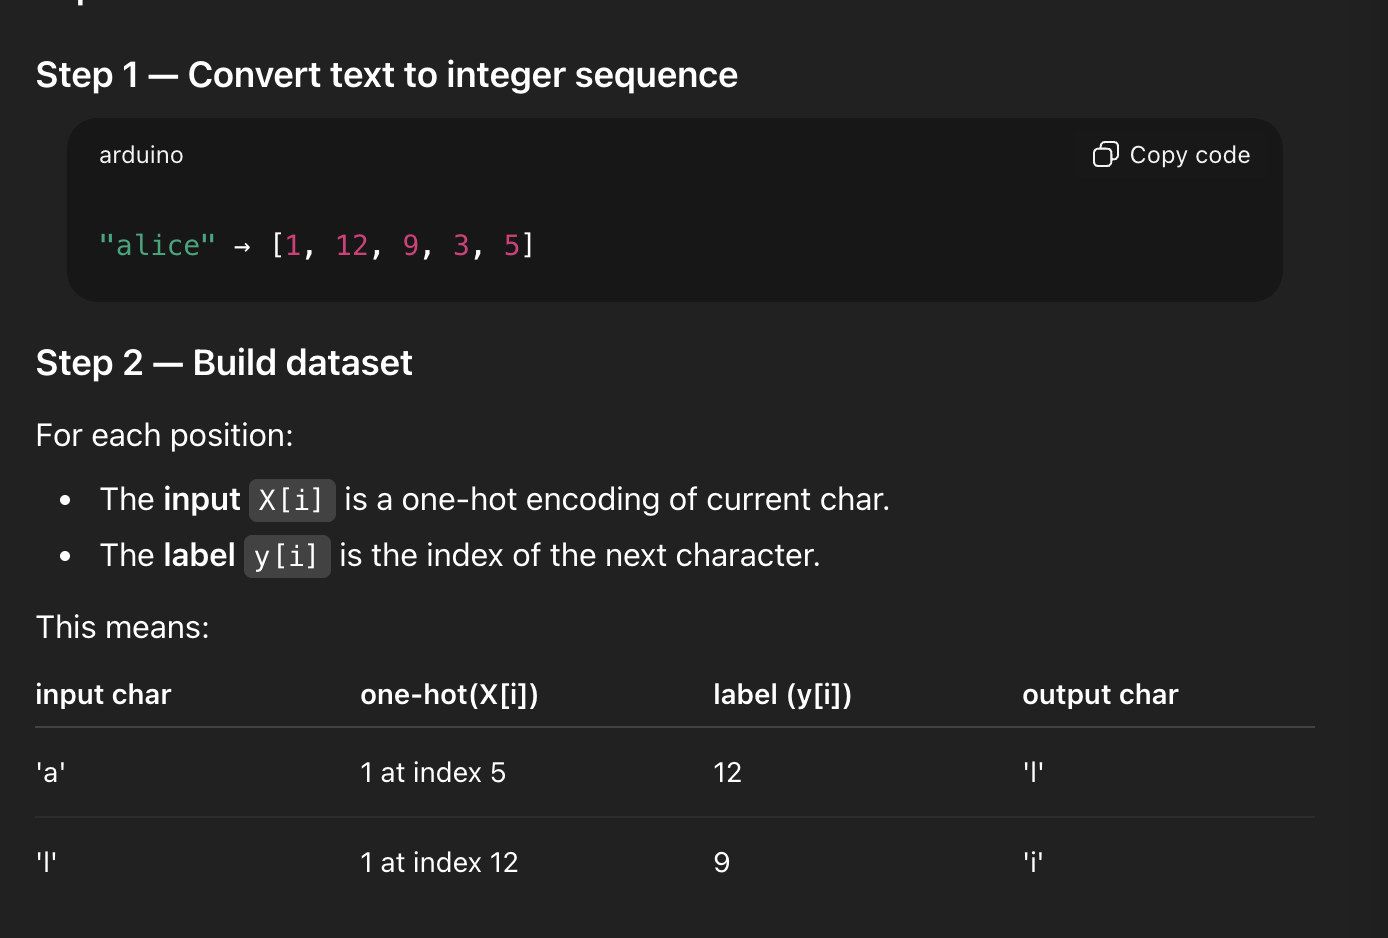


In [ ]:
# Convert full text to list of indices
idxs = [char2idx[ch] for ch in text] #"alice" → [1, 12, 9, 3, 5]

# Build dataset: X = current char one-hot, y = next char index
X = np.zeros((len(idxs)-1, vocab_size), dtype=np.float32)
y = np.zeros(len(idxs)-1, dtype=np.int32)

for i in range(len(idxs)-1):
    X[i, idxs[i]] = 1.0       # one-hot for current char
    y[i] = idxs[i+1]          # next char index

print("Dataset size:", len(X))
print("Example:")
for i in range(5):
    print(idx2char[idxs[i]], "->", idx2char[y[i]])


Dataset size: 148573
Example:
a -> l
l -> i
i -> c
c -> e
e -> '


## Model architecture (single neuron → vocab)

We use:
- Input: one-hot vector of size vocab_size
- Output: logits over all vocab characters

This is equivalent to: `logits = X @ W + b`

Where:
- W is vocab_size × vocab_size
- b is vocab_size

We apply softmax to get probabilities.


In [6]:
W = np.random.randn(vocab_size, vocab_size) * 0.01
b = np.zeros(vocab_size)

print("W shape:", W.shape)


W shape: (46, 46)


### Softmax and Cross-entropy - Ativation function and loss function

In [7]:
def softmax(logits):
    ex = np.exp(logits - np.max(logits, axis=1, keepdims=True))
    return ex / np.sum(ex, axis=1, keepdims=True)

def cross_entropy(y_true, probs):
    # y_true is integer index
    N = len(y_true)
    correct = probs[np.arange(N), y_true]
    return -np.mean(np.log(correct + 1e-12))


## Training loop

We use:
- forward: logits = X @ W + b
- probs = softmax(logits)
- loss = cross-entropy
- backward: gradients for W and b
- SGD update


In [11]:
lr = 1.0
epochs = 2000

for epoch in range(epochs):
    logits = X @ W + b
    probs = softmax(logits)

    loss = cross_entropy(y, probs)

    # Gradient computation
    N = len(y)
    dlogits = probs
    dlogits[np.arange(N), y] -= 1
    dlogits /= N

    dW = X.T @ dlogits
    db = np.sum(dlogits, axis=0)

    # SGD update
    W -= lr * dW
    b -= lr * db

    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {loss:.4f}")


Epoch 0, Loss: 2.4139
Epoch 10, Loss: 2.4139
Epoch 20, Loss: 2.4138
Epoch 30, Loss: 2.4138
Epoch 40, Loss: 2.4138
Epoch 50, Loss: 2.4138
Epoch 60, Loss: 2.4138
Epoch 70, Loss: 2.4137
Epoch 80, Loss: 2.4137
Epoch 90, Loss: 2.4137
Epoch 100, Loss: 2.4137
Epoch 110, Loss: 2.4137
Epoch 120, Loss: 2.4136
Epoch 130, Loss: 2.4136
Epoch 140, Loss: 2.4136
Epoch 150, Loss: 2.4136
Epoch 160, Loss: 2.4136
Epoch 170, Loss: 2.4135
Epoch 180, Loss: 2.4135
Epoch 190, Loss: 2.4135
Epoch 200, Loss: 2.4135
Epoch 210, Loss: 2.4135
Epoch 220, Loss: 2.4135
Epoch 230, Loss: 2.4134
Epoch 240, Loss: 2.4134
Epoch 250, Loss: 2.4134
Epoch 260, Loss: 2.4134
Epoch 270, Loss: 2.4134
Epoch 280, Loss: 2.4133
Epoch 290, Loss: 2.4133
Epoch 300, Loss: 2.4133
Epoch 310, Loss: 2.4133
Epoch 320, Loss: 2.4133
Epoch 330, Loss: 2.4133
Epoch 340, Loss: 2.4132
Epoch 350, Loss: 2.4132
Epoch 360, Loss: 2.4132
Epoch 370, Loss: 2.4132
Epoch 380, Loss: 2.4132
Epoch 390, Loss: 2.4131
Epoch 400, Loss: 2.4131
Epoch 410, Loss: 2.4131
Epo

## Generation

Given a starting character:
- Convert to one-hot
- Compute next-char distribution: softmax(x @ W + b)
- Sample or take argmax
- Feed predicted char as next input
- Continue for N steps


1. Start with a seed character.

2. Get probabilities for next character.

3. Sample from softmax distribution.

4. Feed predicted char back.

5. Repeat.

In [12]:
def generate(start_char, length=200, temperature=1.0):
    current_idx = char2idx[start_char]
    output = start_char
    
    for _ in range(length):
        x = np.zeros((1, vocab_size))
        x[0, current_idx] = 1.0
        
        logits = x @ W + b
        logits = logits / temperature
        probs = softmax(logits)[0]
        
        # sample
        next_idx = np.random.choice(vocab_size, p=probs)
        output += idx2char[next_idx]
        
        current_idx = next_idx
    
    return output

print(generate("a"))


ai'
thers. shathe:

l
 i!r, be
it poumbenocesowimem kidint anasl indourndothier cexthedre, the
s
hthasoow irs the t berkid-ato qin?' olle t, rbalyemid s ainu ids fothe, an.
eve  wablin.
warng anow, wit


# Summary

- This is the smallest possible next-character predictor.
- A single linear layer learns bigram-like transitions: P(next_char | current_char).
- Generation works by sampling next characters repeatedly.
- This behaves like a first-order Markov model, not a real language model.